In [18]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.colors as mcolors
METHODS = ['Base', 'Origin', 'Quant', 'AKCB']
METHOD_ORDER = {"Base": 0, "Origin": 1, "Quant": 2, "AKCB": 3}
# Pleasant gradients: lighter at 512 → darker at 2048
MPL_COLORS = {
    "Base": "#D82E83",  # base color
    "Origin_512": "#8FD19E",  # light green
    "Origin_1024": "#4CAF50",  # medium green
    "Origin_2048": "#2E7D32",  # dark green
    "Quant_512": "#F6B26B",   # light orange
    "Quant_1024": "#F39C12",  # medium orange
    "Quant_2048": "#B85C00",  # dark orange
    "AKCB_512": "#7FC8E7",    # light blue
    "AKCB_1024": "#3498DB",   # medium blue
    "AKCB_2048": "#1B5E7A"    # dark blue
}
# SNS_PALETTE = [MPL_COLORS[m] for m in METHODS]

In [ ]:
tps_old = pd.read_csv('data/tps_aggregated.csv')
model_mapping = {
    'meta-llama_Meta-Llama-3.1-8B-Instruct': 'Llama-3.1-8B',
    'Qwen_Qwen3-8B': 'Qwen3-8B',
    'meta-llama_Llama-3.2-3B-Instruct': 'Llama-3.2-3B',
    'Qwen_Qwen3-4B-Instruct-2507': 'Qwen3-4B'
}
tps_old['model_name'] = tps_old['model'].map(model_mapping)
method_mapping = {
    'base': 'Base',
    'origin': 'Origin',
    'quant': 'Quant',
    'AKCB': 'AKCB'
}
tps_old['method'] = tps_old['method'].map(method_mapping)
tps_old.loc[tps_old['task'].str.startswith('longbench'), 'task_type'] = 'LongBench'
tps_old.loc[tps_old['task'].str.startswith('commonsense'), 'task_type'] = 'CommonQA'
tps_old.loc[tps_old['task'].str.startswith('mmlu'), 'task_type'] = 'MMLU'
tps_old.loc[tps_old['task'].str.startswith('gsm8k'), 'task_type'] = 'GSM8K'
tps_old.head()

,model,method,cache_size,task,task_tokens_per_s,quant_ratio,task_quant_ratio,model_name,task_type
0,meta-llama_Meta-Llama-3.1-8B-Instruct,AKCB,512,longbench_2wikimqa,3278.73,0.154468,0.130704,Llama-3.1-8B,LongBench
1,meta-llama_Meta-Llama-3.1-8B-Instruct,AKCB,512,longbench_dureader,1889.55,0.154468,0.157249,Llama-3.1-8B,LongBench
2,meta-llama_Meta-Llama-3.1-8B-Instruct,AKCB,512,longbench_gov_report,561.67,0.154468,0.140096,Llama-3.1-8B,LongBench
3,meta-llama_Meta-Llama-3.1-8B-Instruct,AKCB,512,longbench_hotpotqa,3786.85,0.154468,0.128947,Llama-3.1-8B,LongBench
4,meta-llama_Meta-Llama-3.1-8B-Instruct,AKCB,512,longbench_lcc,1154.09,0.154468,0.197260,Llama-3.1-8B,LongBench


In [5]:
def categorize_task(task_name):
    """Categorize tasks for analysis"""
    if 'longbench' in task_name:
        if any(x in task_name for x in ['passage', 'count', 'retrieval']):
            return 'Retrieval'
        elif any(x in task_name for x in ['qa', 'hotpot', 'musique', '2wiki']):
            return 'QA'
        elif any(x in task_name for x in ['summary', 'news', 'gov_report']):
            return 'Summarization'
        elif any(x in task_name for x in ['code', 'repobench']):
            return 'Code'
        else:
            return 'LongBench-Other'
    elif any(x in task_name for x in ['commonsense', 'hellaswag', 'piqa']):
        return 'Commonsense'
    elif any(x in task_name for x in ['gsm8k', 'math']):
        return 'Math'
    elif any(x in task_name for x in ['humaneval', 'mbpp']):
        return 'Code'
    elif 'mmlu' in task_name:
        return 'MMLU'
    else:
        return 'Other'

In [6]:
tps_old['task_category'] = tps_old['task'].apply(categorize_task)

In [7]:
def calculate_relative_tps(tps_df):
    """Calculate relative TPS performance compared to base method"""
    results = []
    
    for model in tps_df['model_name'].unique():
        for cache_size in tps_df['cache_size'].unique():
            for task in tps_df['task'].unique():
                subset = tps_df[(tps_df['model_name'] == model) & 
                               (tps_df['cache_size'] == cache_size) & 
                               (tps_df['task'] == task)]
                
                if len(subset) == 0:
                    continue
                    
                base_tps = subset[subset['method'] == 'Base']['task_tokens_per_s']
                
                if len(base_tps) == 0 or base_tps.iloc[0] == 0:
                    continue
                    
                base_tps = base_tps.iloc[0]
                
                for method in METHODS:
                    method_tps = subset[subset['method'] == method]['task_tokens_per_s']
                    
                    if len(method_tps) > 0:
                        method_tps = method_tps.iloc[0]
                        relative_tps = method_tps / base_tps if base_tps > 0 else 0
                        speedup = relative_tps  # speedup factor
                        
                        results.append({
                            'model': model,
                            'budget': cache_size,
                            'task': task,
                            'task_category': subset.iloc[0]['task_category'],
                            'method': method,
                            'base_tps': base_tps,
                            'method_tps': method_tps,
                            'relative_tps': relative_tps,
                            'speedup_factor': speedup,
                            'tps_change_pct': (speedup - 1) * 100
                        })
    
    return pd.DataFrame(results)

In [8]:
cleaned_tps = calculate_relative_tps(tps_old)
cleaned_tps.head()

,model,budget,task,task_category,method,base_tps,method_tps,relative_tps,speedup_factor,tps_change_pct
0,Llama-3.1-8B,512,longbench_2wikimqa,QA,Base,3857.50,3857.50,1.000000,1.000000,0.000000
1,Llama-3.1-8B,512,longbench_2wikimqa,QA,Origin,3857.50,3220.68,0.834914,0.834914,-16.508620
2,Llama-3.1-8B,512,longbench_2wikimqa,QA,Quant,3857.50,3068.13,0.795367,0.795367,-20.463253
3,Llama-3.1-8B,512,longbench_2wikimqa,QA,AKCB,3857.50,3278.73,0.849962,0.849962,-15.003759
4,Llama-3.1-8B,512,longbench_dureader,LongBench-Other,Base,1925.88,1925.88,1.000000,1.000000,0.000000


In [51]:
def plot_relative_tps_comparison(df, tasks=None, model_name=None, group_by=None, figsize=(12, 6), target='TPS'):
    """
    Plot bar chart comparing relative tps (Base = 1.0) across budgets
    
    Parameters:
    - df: DataFrame with columns ['model_name', 'method', 'budget', 'task', 'TPS', 'Task Type', 'Language']
    - tasks: list of task names to include (None for all tasks)
    - model_name: specific model to plot (None for all models averaged)
    - group_by: column to group by ('Task Type', 'Language', or None for tasks)
    - figsize: figure size
    """
    # Filter data
    if model_name:
        plot_data = df[df['model_name'] == model_name].copy()
        title_suffix = f" - {model_name}"
    else:
        plot_data = df.copy()
        title_suffix = " - All Models (Averaged)"
    
    # Filter tasks if specified
    if tasks is not None:
        plot_data = plot_data[plot_data['task'].isin(tasks)]
    
    # Aggregate by method and budget based on grouping
    if group_by:
        # Group by the specified column (Task Type or Language)
        agg_data = plot_data.groupby(['method', 'budget', group_by], dropna=False)[target].mean().reset_index()
        # Average across the group
        agg_data = agg_data.groupby(['method', 'budget'], dropna=False)[target].mean().reset_index()
        title_suffix += f" - Grouped by {group_by}"
    else:
        # Aggregate by method and budget (dropna=False to keep NaN budgets for Base)
        agg_data = plot_data.groupby(['method', 'budget'], dropna=False)[target].mean().reset_index()
    
    # Separate Base (no budget) and compression methods
    base_data = agg_data[agg_data['method'] == 'Base'].copy()
    compress_data = agg_data[agg_data['method'].isin(['Origin', 'Quant', 'AKCB'])].copy()
    
    # Get Base performance (same across all budgets)
    base_perf = base_data[target].values[0] if len(base_data) > 0 else None
    
    if base_perf is None or base_perf == 0:
        print(f"Warning: Base {target} is None or 0, cannot compute relative {target}")
        return None, None
    
    # Prepare data for plotting
    budgets = sorted(compress_data['budget'].unique())
    x = np.arange(len(budgets))  # Budget positions
    width = 0.2  # Width of each bar (4 bars now)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot bars for Base, Origin, Quant, AKCB
    for i, method in enumerate(['Base', 'Origin', 'Quant', 'AKCB']):
        if method == 'Base':
            # Base is normalized to 1.0
            performances = [1.0] * len(budgets)
        else:
            method_data = compress_data[compress_data['method'] == method]
            performances = [method_data[method_data['budget'] == b][target].values[0] / base_perf
                           if len(method_data[method_data['budget'] == b]) > 0 else 0 
                           for b in budgets]
        
        offset = (i - 1.5) * width  # Center the 4 bars
        ax.bar(x + offset, performances, width, label=method, 
               color=MPL_COLORS[method], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add horizontal line at y=1.0 for reference
    ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Customize plot
    ax.set_xlabel('Cache Budget (tokens)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Relative {target} (Base = 1.0)', fontsize=12, fontweight='bold')
    ax.set_title(f'Relative {target} Across Budgets{title_suffix}', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(budgets)
    ax.legend(loc='lower right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    return fig, ax

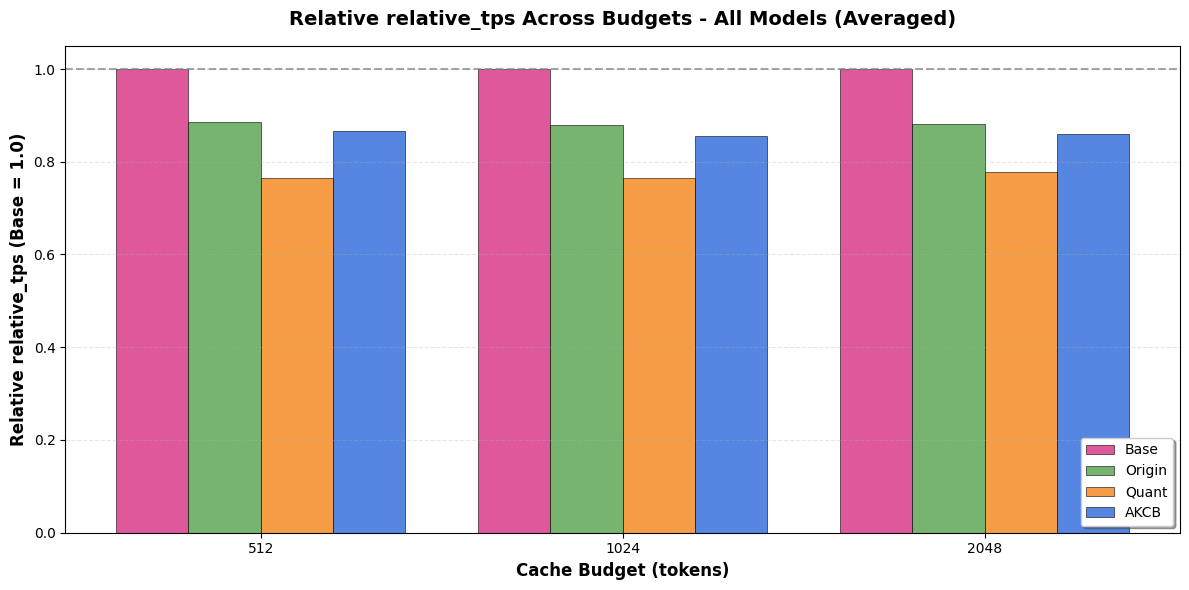

In [52]:
fig, ax = plot_relative_tps_comparison(cleaned_tps, target='relative_tps')
fig.show()

/tmp/ipykernel_1579966/2555936964.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_tps, x='method', y='relative_tps', order=method_order, palette=palette)


<Figure size 1200x600 with 0 Axes>

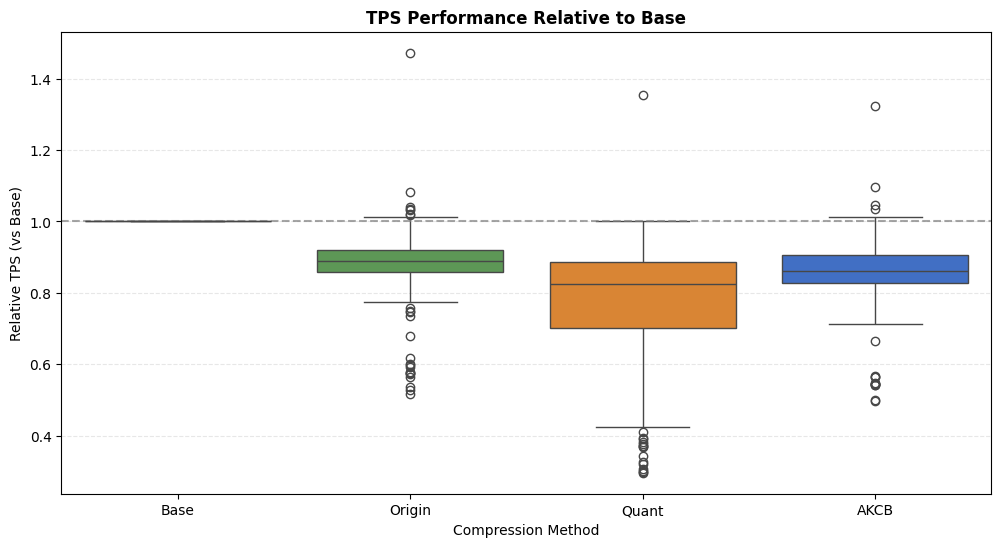

In [26]:
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))
# Overall TPS comparison
method_order = METHODS
palette = [MPL_COLORS[m] for m in method_order]

sns.boxplot(data=cleaned_tps, x='method', y='relative_tps', order=method_order, palette=palette)
plt.title('TPS Performance Relative to Base', fontweight='bold')
plt.xlabel('Compression Method')
plt.ylabel('Relative TPS (vs Base)')
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
# ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
root = Path('/var/scratch/jle385/thesis/adkv/experiments/analysis/plots/tps')
root.mkdir(parents=True, exist_ok=True)
plt.savefig(root / 'tps_performance_relative_to_base.png', dpi=300, bbox_inches='tight')

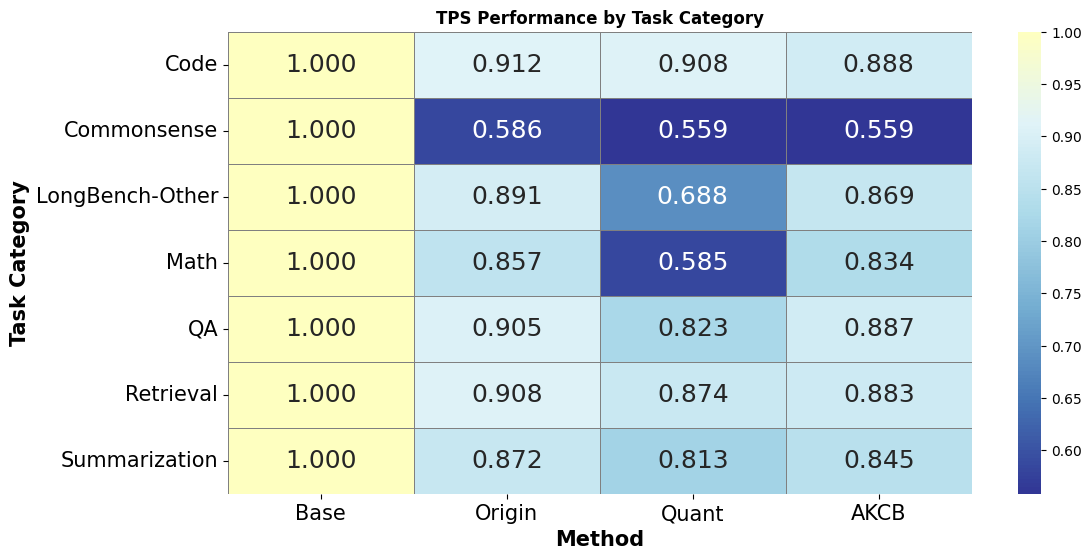

In [31]:
plt.figure(figsize=(12, 6))
category_tps = cleaned_tps.pivot_table(values='relative_tps', 
                                         index='task_category', 
                                         columns='method', 
                                         aggfunc='mean')
category_tps = category_tps.reindex(columns=METHODS)
    
sns.heatmap(category_tps, annot=True, fmt='.3f', cmap='RdYlBu_r',
            center=1.0, annot_kws={'fontsize': 18}, 
            linewidths=0.5, linecolor='gray')
plt.title('TPS Performance by Task Category', fontweight='bold')
plt.xlabel('Method', fontsize=15, fontweight='bold')
plt.ylabel('Task Category', fontsize=15, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=15)
# ax.set_xlabel('Method', fontsize=15, fontweight='bold')
# ax.set_ylabel('Task Category', fontsize=15, fontweight='bold')
# ax.set_title('TPS Performance by Task Category', 
#                 fontsize=15, fontweight='bold', pad=15)
# ax.tick_params(axis='both', which='major', labelsize=15)
# char = ax.collections[0].colorbar
# char.ax.tick_params(labelsize=15)
# char.set_label('Relative Performance', fontsize=15, fontweight='bold')
plt.savefig(root / 'tps_performance_by_task_category.png', dpi=300, bbox_inches='tight')
# plt.show()

<Figure size 1400x700 with 0 Axes>

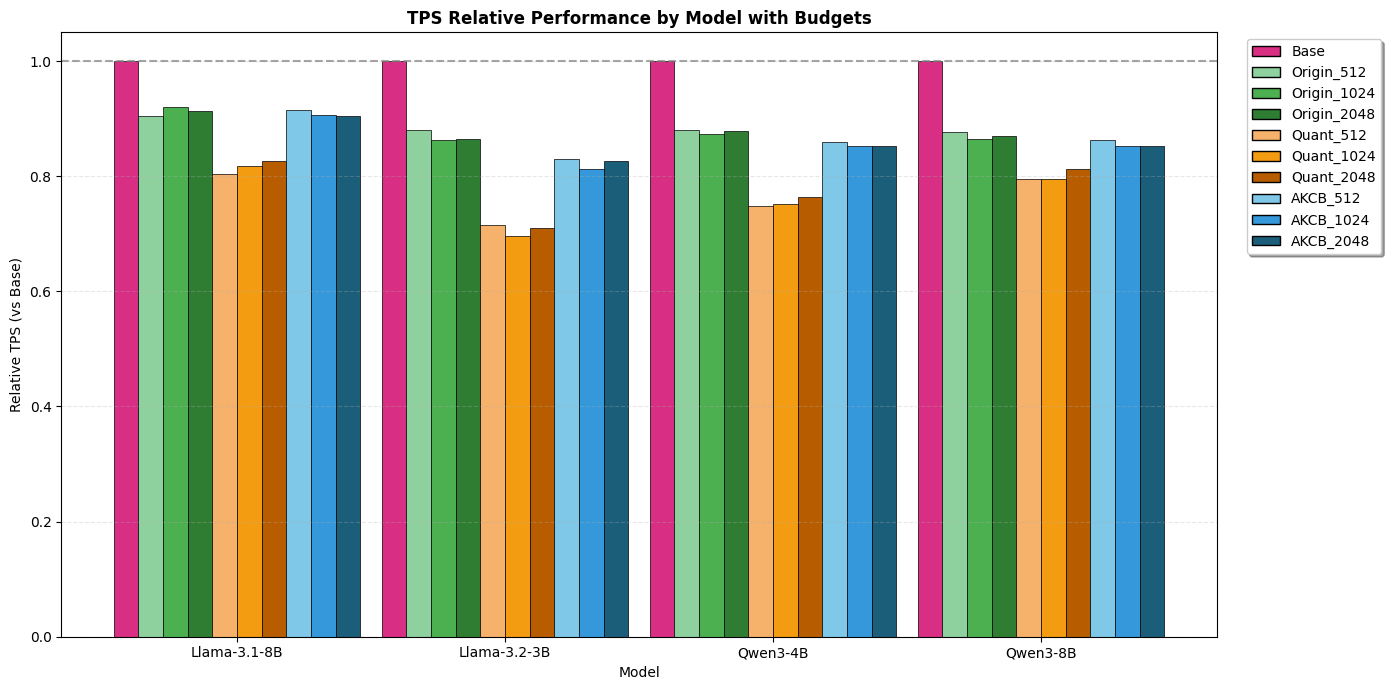

In [19]:
# Combined per-model grouped bar chart with budgets per method
order_cols = [
    'Base',
    'Origin_512', 'Origin_1024', 'Origin_2048',
    'Quant_512', 'Quant_1024', 'Quant_2048',
    'AKCB_512', 'AKCB_1024', 'AKCB_2048'
]
color_map = {
    'Base': MPL_COLORS['Base'],
    'Origin_512': MPL_COLORS['Origin_512'],
    'Origin_1024': MPL_COLORS['Origin_1024'],
    'Origin_2048': MPL_COLORS['Origin_2048'],
    'Quant_512': MPL_COLORS['Quant_512'],
    'Quant_1024': MPL_COLORS['Quant_1024'],
    'Quant_2048': MPL_COLORS['Quant_2048'],
    'AKCB_512': MPL_COLORS['AKCB_512'],
    'AKCB_1024': MPL_COLORS['AKCB_1024'],
    'AKCB_2048': MPL_COLORS['AKCB_2048'],
}

# Build method_budget labels
plot_df = cleaned_tps.copy()
plot_df['method_budget'] = np.where(
    plot_df['method'] == 'Base',
    'Base',
    plot_df['method'] + '_' + plot_df['budget'].astype(str)
)

# Aggregate mean relative TPS per model and method_budget
model_mb = (
    plot_df.groupby(['model', 'method_budget'])['relative_tps']
    .mean()
    .unstack()
)
# Ensure all columns in desired order exist
for c in order_cols:
    if c not in model_mb.columns:
        model_mb[c] = np.nan
model_mb = model_mb[order_cols]

# Plot
plt.figure(figsize=(14, 7))
fig, ax = plt.subplots(figsize=(14, 7))
models = list(model_mb.index)
n_bars_per_model = len(order_cols)
bar_width = 0.08
model_spacing = 0.15  # extra gap between model groups

# Compute x positions: consecutive bars per model, then a gap
positions = []
current_x = 0.0
for _ in models:
    # bars for this model
    positions.extend([current_x + i * bar_width for i in range(n_bars_per_model)])
    # add spacing before next model
    current_x = positions[-1] + model_spacing

# Draw bars
colors = [color_map[c] for c in order_cols]
for mi, model in enumerate(models):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    yvals = model_mb.loc[model, order_cols].values
    ax.bar(positions[start:end], yvals, width=bar_width, color=colors,
           edgecolor='black', linewidth=0.5)

# Reference line at 1.0
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# X ticks: put one tick centered under each model group
model_centers = []
for mi in range(len(models)):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    center = np.mean(positions[start:end])
    model_centers.append(center)
ax.set_xticks(model_centers)
ax.set_xticklabels(models, rotation=0)

# Legend: show one patch per column type
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=color_map[c], edgecolor='black', label=c) for c in order_cols]
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True, shadow=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.title('TPS Relative Performance by Model with Budgets', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Relative TPS (vs Base)')
root = Path('/var/scratch/jle385/thesis/adkv/experiments/analysis/plots/tps')
root.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(root / 'tps_per_model_grouped_budgets.png', dpi=300, bbox_inches='tight')

<Figure size 1200x600 with 0 Axes>

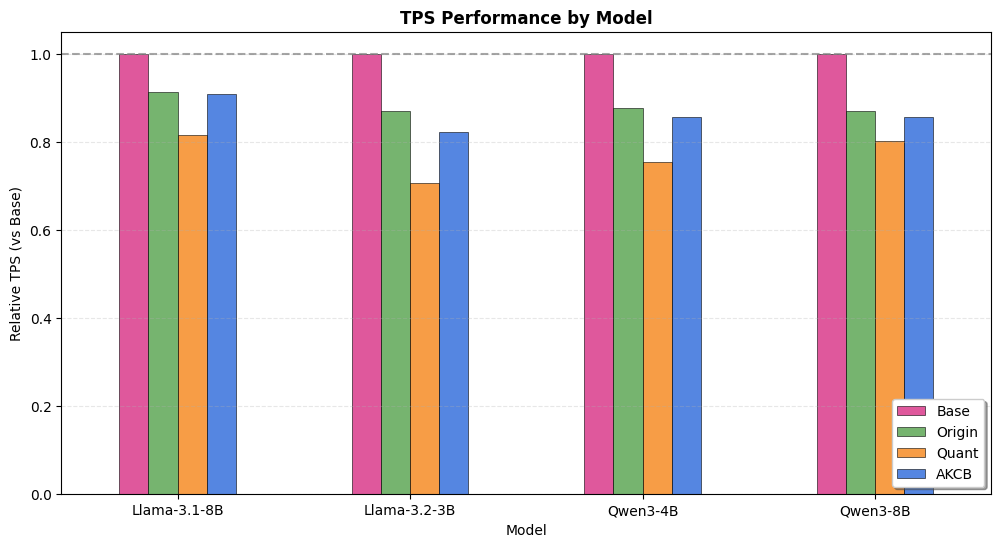

In [ ]:
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))
# Overall TPS comparison
method_order = METHODS
palette = [MPL_COLORS[m] for m in method_order]
model_tps = cleaned_tps.groupby(['model', 'method'])['relative_tps'].mean().unstack()
model_tps = model_tps.reindex(columns=METHODS)
model_tps.plot(kind='bar', ax=plt.gca(), rot=0, alpha=0.8, edgecolor='black', linewidth=0.5, color=palette)
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--' )
plt.title('TPS Performance by Model', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Relative TPS (vs Base)')
plt.savefig(root / 'tps_performance_by_model.png', dpi=300, bbox_inches='tight')

<Figure size 1200x600 with 0 Axes>

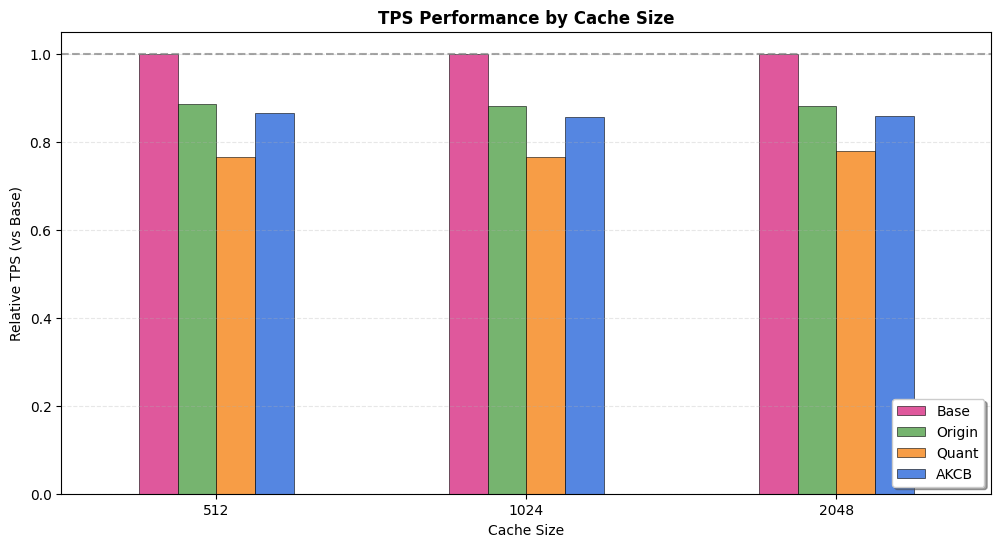

In [57]:
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))
cache_tps = cleaned_tps.pivot_table(values='relative_tps', 
                                      index='budget', 
                                      columns='method', 
                                      aggfunc='mean')
method_order = METHODS
palette = [MPL_COLORS[m] for m in method_order]
cache_tps = cache_tps.reindex(columns=METHODS)
cache_tps.plot(kind='bar', ax=plt.gca(), rot=0, color=palette, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--' )
plt.title('TPS Performance by Cache Size', fontweight='bold')
plt.xlabel('Cache Size')
plt.ylabel('Relative TPS (vs Base)')
plt.savefig(root / 'tps_performance_by_cache_size.png', dpi=300, bbox_inches='tight')

In [62]:
quant_tps = cleaned_tps[cleaned_tps['method'] == 'AKCB']
quant_tps.head()

,model,budget,task,task_category,method,base_tps,method_tps,relative_tps,speedup_factor,tps_change_pct
3,Llama-3.1-8B,512,longbench_2wikimqa,QA,AKCB,3857.50,3278.73,0.849962,0.849962,-15.003759
7,Llama-3.1-8B,512,longbench_dureader,LongBench-Other,AKCB,1925.88,1889.55,0.981136,0.981136,-1.886410
11,Llama-3.1-8B,512,longbench_gov_report,Summarization,AKCB,575.46,561.67,0.976037,0.976037,-2.396344
15,Llama-3.1-8B,512,longbench_hotpotqa,QA,AKCB,3945.06,3786.85,0.959897,0.959897,-4.010332
19,Llama-3.1-8B,512,longbench_lcc,LongBench-Other,AKCB,1349.94,1154.09,0.854919,0.854919,-14.508052


In [60]:
def create_memory_analysis(quant_df, save_dir):
    """Create memory savings analysis based on FP8 quantization ratios"""
    plt.figure(figsize=(14, 10))
    
    # Quantization ratio distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data=quant_df, x='task_quant_ratio', bins=30, kde=True)
    plt.title('Distribution of FP8 Quantization Ratios', fontweight='bold')
    plt.xlabel('FP8 Quantization Ratio')
    plt.ylabel('Frequency')
    plt.axvline(quant_df['task_quant_ratio'].mean(), color='red', linestyle='--', 
                label=f'Mean: {quant_df["task_quant_ratio"].mean():.3f}')
    plt.legend()
    
    # Memory savings estimation
    # Assuming quantization ratio represents the portion of cache that uses lower precision
    # Typical memory savings: FP16 to INT8 = 50% savings, FP16 to FP8 = 50% savings
    
    # Calculate memory savings for different precision reductions
    quant_df['memory_saving_fp8'] = quant_df['task_quant_ratio'] * 0.50  # FP16 -> FP8
    
    plt.subplot(2, 2, 2)
    savings_data = pd.DataFrame({
        'FP8 (50% per token)': quant_df['memory_saving_fp8'] * 100
    })
    
    savings_data.plot(kind='hist', bins=20, alpha=0.7, ax=plt.gca())
    plt.title('Estimated Memory Savings Distribution\n(FP8 Quantization)', fontweight='bold')
    plt.xlabel('Memory Savings (%)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Quantization ratio by task category
    plt.subplot(2, 2, 3)
    category_quant = quant_df.groupby('task_category')['task_quant_ratio'].agg(['mean', 'std'])
    category_quant['mean'].plot(kind='bar', yerr=category_quant['std'], 
                               ax=plt.gca(), capsize=5, rot=45)
    plt.title('FP8 Quantization Ratio by Task Category', fontweight='bold')
    plt.xlabel('Task Category')
    plt.ylabel('Average FP8 Quantization Ratio')
    plt.grid(axis='y', alpha=0.3)
    
    # Task-specific quantization ratios (top 15)
    plt.subplot(2, 2, 4)
    task_quant = quant_df.groupby('task')['task_quant_ratio'].mean().sort_values(ascending=False).head(15)
    task_quant.plot(kind='barh', ax=plt.gca())
    plt.title('Top 15 Tasks by FP8 Quantization Ratio', fontweight='bold')
    plt.xlabel('FP8 Quantization Ratio')
    plt.ylabel('Task')
    
    plt.tight_layout()
    # plt.savefig(f'{save_dir}/memory_savings_analysis.png', dpi=300, bbox_inches='tight')
    # plt.close()
    
    return savings_data